<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:15<00:00, 11.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 0.9583, Train Accuracy: 67.34%
Test Accuracy: 73.03%
Confusion Matrix (Epoch 1):
[[594  15 184  18  35   3  13  27  94  17]
 [  9 804  20  22   1  10  30  11  21  72]
 [ 11   0 805  21  56  25  31  44   5   2]
 [  7   1 127 589  35 113  28  87   8   5]
 [  7   0 100  59 636   8  34 144  12   0]
 [  2   0 129 125  28 590   9 113   4   0]
 [  1   0  83  99   9  11 784  11   2   0]
 [  6   1  38  13   9  18   4 899   7   5]
 [ 23  21  47  21   6   2   4   3 863  10]
 [ 42  81  15  28   1  10  21  26  37 739]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.7221, Train Accuracy: 75.50%
Test Accuracy: 76.86%
Confusion Matrix (Epoch 2):
[[939  12   7   5   7   3   2   8   9   8]
 [ 36 900   4   2   2   1   1   6   9  39]
 [134   3 669  40  51  68  10  15   5   5]
 [ 56   9  56 584  52 177  22  30   8   6]
 [ 35   1  67  40 801  15   8  28   4   1]
 [ 22   5  18 109  46 754   5  36   1   4]
 [ 18   8  70  83  40  31 730  12   6   2]
 [ 23   0  23  37  67  43   0 805   0   2]
 [204  36   8   8   1   0   2   6 725  10]
 [ 70  94   3   8   7   3   1  24  11 779]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.6239, Train Accuracy: 78.74%
Test Accuracy: 78.10%
Confusion Matrix (Epoch 3):
[[775  13  43   9   4   2   8   7 121  18]
 [ 16 762   8   5   1   1  18   0 104  85]
 [ 57   3 762  34  49  26  36  16  15   2]
 [ 20   9  64 627  30 118  50  30  33  19]
 [ 18   2  69  50 727  22  28  59  22   3]
 [ 12   1  41 160  22 698  21  34   7   4]
 [  7   4  39  46  20  18 854   3   7   2]
 [ 21   2  31  33  23  35   7 838   5   5]
 [ 20  11   9   3   0   1   2   1 949   4]
 [ 28  44  11   8   2   5   7   7  70 818]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.5494, Train Accuracy: 81.14%
Test Accuracy: 81.25%
Confusion Matrix (Epoch 4):
[[842   7  22   7  16   1  12  12  65  16]
 [ 20 885   2   2   0   1   8   3  11  68]
 [ 37   2 713  20  86  24  89  17   5   7]
 [ 12  11  45 618  55  89 120  19  14  17]
 [  4   3  19  42 837  18  48  21   7   1]
 [  8   5  23 171  52 654  50  25   4   8]
 [  3   3  10  16  19   4 938   4   2   1]
 [ 10   0  19  36  36  30   9 850   1   9]
 [ 41  21   4   9   2   0   7   2 901  13]
 [ 34  40   6   5   0   2   8   2  16 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.5387, Train Accuracy: 81.62%
Test Accuracy: 81.20%
Confusion Matrix (Epoch 5):
[[896  11  12   3   6   1   0   4  57  10]
 [ 24 910   6   4   3   0   2   2  33  16]
 [ 72   3 748  31  82  10  33  12   7   2]
 [ 34   4  51 687  70  59  40  21  27   7]
 [ 15   1  24  25 890   3  16  18   8   0]
 [ 15   1  52 201  50 607  20  40  12   2]
 [ 14   6  28  35  33   6 865   4   7   2]
 [ 18   2  28  31  53  12   0 843  10   3]
 [ 47   9   9   4   1   2   0   1 924   3]
 [ 43 133   4   7   2   1   0   3  57 750]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.4531, Train Accuracy: 84.24%
Test Accuracy: 82.20%
Confusion Matrix (Epoch 6):
[[873   7  10  13  13   5   4  16  33  26]
 [ 12 879   4   6   2   8   1   1  12  75]
 [ 67   3 695  44  71  71  26  15   7   1]
 [ 12   0  23 655  27 243  10  17   8   5]
 [  6   1  19  62 807  63  13  23   5   1]
 [  5   0  13  87  18 858   4  13   0   2]
 [  9   1  14  99  15  38 817   5   2   0]
 [  4   0  10  12  24 103   2 838   1   6]
 [ 44  13   5   8   3   6   2   2 901  16]
 [ 13  32   6  19   1   8   2   6  16 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.4230, Train Accuracy: 85.33%
Test Accuracy: 83.71%
Confusion Matrix (Epoch 7):
[[807  15  33   5  10   2   3   4  77  44]
 [  6 916   1   1   0   2   1   1  18  54]
 [ 29   2 804  26  39  27  32  18  15   8]
 [ 19   6  49 707  42 103  27  22  10  15]
 [  9   3  47  39 791  21  39  41   9   1]
 [  9   1  26 134  34 743  11  35   3   4]
 [  6   2  31  51   6  12 881   3   3   5]
 [ 11   2  12  28  24  28   1 888   2   4]
 [ 22  22   3   8   1   0   1   1 928  14]
 [ 14  43   5   6   2   3   0   3  18 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.6085, Train Accuracy: 80.04%
Test Accuracy: 52.10%
Confusion Matrix (Epoch 8):
[[536  21 246  11  14   6  24  25  71  46]
 [110 383  26   6   3  12  35  30  33 362]
 [ 76   6 490  24 109  85  95  72  13  30]
 [ 37   7 125 203  62 256 122 118  23  47]
 [ 33   5 116  23 484  45  82 184  10  18]
 [ 21   9 136  47  45 505  60 138   6  33]
 [ 17  10  53  17  70  35 717  55   8  18]
 [ 30   5  52  10  28  47  28 754   7  39]
 [324  24  82  11   7   8  32   8 420  84]
 [ 94  41  25   8   5  10  25  45  29 718]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.7112, Train Accuracy: 76.35%
Test Accuracy: 80.42%
Confusion Matrix (Epoch 9):
[[760  25  48  10  14   6   6  13  65  53]
 [  4 882   1   4   1   4   3   3  30  68]
 [ 44   3 714  32  81  37  43  32   7   7]
 [ 24   8  33 621  53 174  45  24   9   9]
 [  7   2  25  27 846  24  23  34  11   1]
 [  9   2  17 115  42 759  19  26   4   7]
 [ 10   6  20  52  29  23 845   4   5   6]
 [  9   1   5  27  36  45   5 854   5  13]
 [ 61  16  10   8   1   3   1   3 881  16]
 [ 15  52   3   9   0   6   1   4  30 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.4344, Train Accuracy: 84.97%
Test Accuracy: 83.48%
Confusion Matrix (Epoch 10):
[[817  10  59   9  10   0   9   3  52  31]
 [  8 867   6   5   0   0   4   0  29  81]
 [ 22   2 866  20  31  16  25   9   6   3]
 [ 14   1  71 675  41 109  46  10  10  23]
 [  5   1  49  31 821  17  22  43   7   4]
 [ 10   0  38 131  34 734  18  23   8   4]
 [  6   1  41  35   9   9 895   2   1   1]
 [  8   1  24  35  18  38   4 859   3  10]
 [ 32  15  12   7   4   0   0   0 916  14]
 [ 24  41   4   6   0   0   6   5  16 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.3001, Train Accuracy: 89.77%
Test Accuracy: 85.74%
Confusion Matrix (Epoch 11):
[[894  10  22  10   9   0   5   4  36  10]
 [ 11 926   1   4   0   0   1   0  15  42]
 [ 32   1 845  26  39  17  22  15   2   1]
 [ 16   3  43 723  31 126  33  16   3   6]
 [  7   1  33  36 843  19  20  36   4   1]
 [  4   1  25 113  27 787  12  25   4   2]
 [  7   3  32  40   9  14 892   2   1   0]
 [ 10   2  15  29  12  35   2 890   2   3]
 [ 49  19   6  13   1   0   0   1 901  10]
 [ 30  57   3   9   1   3   3   5  16 873]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.2602, Train Accuracy: 91.09%
Test Accuracy: 86.15%
Confusion Matrix (Epoch 12):
[[907   9  13   7   6   0   5   2  39  12]
 [ 11 928   1   3   0   0   2   0  19  36]
 [ 37   1 846  25  38  13  21  15   3   1]
 [ 20   1  46 727  39 101  34  19   8   5]
 [ 10   1  31  34 858  16  22  22   5   1]
 [  9   1  29 123  28 765  11  24   7   3]
 [  7   4  29  40  10   9 897   1   2   1]
 [ 11   3  14  24  23  28   2 888   2   5]
 [ 45  14   4   7   1   0   0   1 922   6]
 [ 25  57   4   7   0   2   3   4  21 877]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.2429, Train Accuracy: 91.67%
Test Accuracy: 86.54%
Confusion Matrix (Epoch 13):
[[896   9  21   8   7   0   5   3  41  10]
 [ 12 926   1   2   0   1   3   0  16  39]
 [ 28   1 847  29  38  18  20  16   2   1]
 [ 16   1  38 730  35 121  31  18   5   5]
 [  7   1  33  32 853  17  18  32   6   1]
 [  6   1  24 110  26 792   8  26   5   2]
 [  7   4  27  37   9  10 902   2   1   1]
 [  9   3  12  23  15  33   1 900   1   3]
 [ 40  14   8   6   3   0   0   1 923   5]
 [ 23  48   4   8   0   3   3   4  22 885]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.2303, Train Accuracy: 92.03%
Test Accuracy: 86.44%
Confusion Matrix (Epoch 14):
[[905   8  15   7   7   0   3   3  40  12]
 [ 12 933   0   2   1   0   3   0  18  31]
 [ 29   1 841  37  36  22  20  11   2   1]
 [ 18   2  36 752  33 111  22  15   5   6]
 [  8   1  40  43 840  16  25  21   5   1]
 [  7   1  23 123  25 790   7  18   3   3]
 [  8   3  26  43   8  10 896   2   3   1]
 [ 11   3  13  27  24  38   1 878   1   4]
 [ 42  10   5   7   3   0   0   0 926   7]
 [ 27  51   3   8   0   2   3   3  20 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.2136, Train Accuracy: 92.56%
Test Accuracy: 86.31%
Confusion Matrix (Epoch 15):
[[906  11  15   8   6   0   2   4  36  12]
 [ 14 929   0   3   0   1   1   0  14  38]
 [ 32   1 839  26  37  22  22  17   3   1]
 [ 19   2  36 746  35 112  24  15   4   7]
 [ 10   3  35  36 829  19  23  38   6   1]
 [  8   1  20 125  25 784   7  27   1   2]
 [  7   5  24  41   8  12 895   3   2   3]
 [ 11   3  11  19  13  37   0 901   1   4]
 [ 44  17   5   6   2   0   0   0 918   8]
 [ 26  55   2   7   0   1   2   5  18 884]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.1977, Train Accuracy: 93.14%
Test Accuracy: 86.36%
Confusion Matrix (Epoch 16):
[[898   8  17   7   7   0   4   4  42  13]
 [ 13 932   0   3   1   2   2   0  17  30]
 [ 31   1 837  30  39  22  26   9   4   1]
 [ 18   3  33 733  39 122  26  16   3   7]
 [  9   2  30  37 839  23  25  28   6   1]
 [  8   0  16 102  31 809   7  22   4   1]
 [  6   3  29  40  10  11 896   3   1   1]
 [ 11   2   8  22  20  35   0 897   1   4]
 [ 36  14   5   8   3   0   0   0 929   5]
 [ 30  63   2   7   0   2   2   5  23 866]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.1891, Train Accuracy: 93.43%
Test Accuracy: 86.25%
Confusion Matrix (Epoch 17):
[[900   7  17  10   8   0   3   4  40  11]
 [ 15 926   0   3   1   1   3   1  16  34]
 [ 30   1 824  33  43  23  23  18   2   3]
 [ 16   1  32 738  31 131  24  18   2   7]
 [  9   1  28  42 833  26  24  31   5   1]
 [  7   0  20 114  29 802   7  20   1   0]
 [  6   2  22  43   8  11 903   3   1   1]
 [ 11   3  10  22  20  36   1 891   1   5]
 [ 38  11   5  10   3   0   0   0 924   9]
 [ 27  56   2   8   0   1   3   1  18 884]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.1724, Train Accuracy: 94.05%
Test Accuracy: 86.67%
Confusion Matrix (Epoch 18):
[[890  11  22   7   8   0   4   4  39  15]
 [ 12 932   0   2   1   0   2   0  17  34]
 [ 21   2 856  22  47  16  19  16   0   1]
 [ 16   3  43 722  38 126  22  18   3   9]
 [  8   1  37  30 847  21  21  28   5   2]
 [  5   0  25 104  33 802   6  19   3   3]
 [  7   2  32  36  12  10 897   2   1   1]
 [ 10   2  13  18  15  33   1 902   1   5]
 [ 32  15   7   4   3   0   0   0 932   7]
 [ 19  60   3   7   0   1   3   3  17 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.1578, Train Accuracy: 94.55%
Test Accuracy: 86.35%
Confusion Matrix (Epoch 19):
[[898  10  22   5   3   0   4   4  42  12]
 [ 15 926   0   3   1   0   3   1  16  35]
 [ 27   1 851  27  32  21  26  10   2   3]
 [ 19   3  38 728  38 113  33  16   6   6]
 [  9   1  37  38 832  18  24  31   7   3]
 [  5   1  19 118  30 786   7  24   8   2]
 [  7   3  28  30   9  10 909   1   2   1]
 [ 13   3  15  22  19  32   0 890   1   5]
 [ 38  11   6   7   2   0   0   0 929   7]
 [ 25  55   2   8   0   0   4   2  18 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.1486, Train Accuracy: 94.81%
Test Accuracy: 86.41%
Confusion Matrix (Epoch 20):
[[898   8  27   5   8   0   3   4  29  18]
 [ 15 920   0   2   1   1   3   1  16  41]
 [ 18   2 850  31  39  19  23  15   0   3]
 [ 20   3  36 712  39 133  26  19   5   7]
 [ 10   1  39  45 823  22  21  33   5   1]
 [  6   3  17 100  30 810   8  24   0   2]
 [  4   2  31  35   9  13 900   3   1   2]
 [  8   1  14  17  14  32   0 908   1   5]
 [ 40  11   7   7   3   0   0   1 919  12]
 [ 24  38   4   9   0   1   3   4  16 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.1357, Train Accuracy: 95.31%
Test Accuracy: 86.26%
Confusion Matrix (Epoch 21):
[[901  10  21   5   8   0   4   3  33  15]
 [ 14 930   0   2   1   1   3   0  15  34]
 [ 22   2 850  33  35  17  26  13   1   1]
 [ 21   3  35 730  39 115  29  16   5   7]
 [ 11   2  40  43 820  19  29  30   5   1]
 [  6   3  18 114  31 801   9  16   1   1]
 [  4   3  28  39   9   9 904   2   1   1]
 [ 13   3  17  17  21  39   0 885   1   4]
 [ 39  14   7   7   3   0   0   1 922   7]
 [ 28  52   3   9   0   1   4   3  17 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.1302, Train Accuracy: 95.46%
Test Accuracy: 86.52%
Confusion Matrix (Epoch 22):
[[896   9  20   6   9   0   4   4  38  14]
 [ 14 924   0   3   1   2   3   0  17  36]
 [ 21   1 846  30  41  20  25  14   1   1]
 [ 19   2  32 722  42 127  26  18   5   7]
 [  7   1  35  43 831  23  26  28   6   0]
 [  6   2  17 104  31 818   6  15   0   1]
 [  5   2  29  36  10  13 901   2   1   1]
 [  9   2  13  17  17  37   0 901   1   3]
 [ 34  11   7   7   3   0   0   1 931   6]
 [ 27  53   5   7   0   1   4   3  18 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.1258, Train Accuracy: 95.65%
Test Accuracy: 86.35%
Confusion Matrix (Epoch 23):
[[900  10  20   8  10   0   4   4  30  14]
 [ 13 927   0   2   1   2   3   0  16  36]
 [ 22   1 846  27  44  20  27  12   0   1]
 [ 18   3  35 719  42 127  28  17   4   7]
 [  9   1  35  43 837  22  26  23   4   0]
 [  6   2  20 107  33 810   7  14   0   1]
 [  4   1  28  38   9  12 904   2   1   1]
 [  9   3  16  18  21  39   0 889   1   4]
 [ 39  16   8   8   3   0   1   1 917   7]
 [ 22  55   4   8   0   1   5   3  16 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.1226, Train Accuracy: 95.70%
Test Accuracy: 86.53%
Confusion Matrix (Epoch 24):
[[893   9  22   7  10   0   4   4  37  14]
 [ 13 928   0   4   1   1   2   1  15  35]
 [ 20   2 864  29  37  15  18  13   1   1]
 [ 17   3  36 746  41 106  22  18   4   7]
 [  7   1  39  42 835  19  21  29   6   1]
 [  6   2  21 126  33 785   6  18   2   1]
 [  6   3  32  42   9   9 895   2   1   1]
 [  8   2  15  19  20  30   0 902   1   3]
 [ 36  14   7   7   3   0   0   0 926   7]
 [ 26  56   5   7   0   1   4   4  18 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.1252, Train Accuracy: 95.68%
Test Accuracy: 86.54%
Confusion Matrix (Epoch 25):
[[902   9  16   5   8   0   4   4  38  14]
 [ 14 929   0   2   1   2   2   0  16  34]
 [ 27   2 845  31  39  18  21  15   1   1]
 [ 18   3  34 729  41 117  24  22   5   7]
 [  8   1  33  42 828  23  24  33   6   2]
 [  6   2  19 110  30 801   6  23   2   1]
 [  7   3  31  38  10  11 894   3   1   2]
 [ 10   2  10  15  15  31   0 912   1   4]
 [ 37  12   6   7   3   0   0   1 929   5]
 [ 22  57   4   7   0   1   3   3  18 885]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.1207, Train Accuracy: 95.79%
Test Accuracy: 86.75%
Confusion Matrix (Epoch 26):
[[901   8  21   5   9   0   4   4  35  13]
 [ 14 925   0   3   1   2   3   0  15  37]
 [ 22   2 857  27  44  16  18  13   0   1]
 [ 21   2  43 719  39 124  26  16   3   7]
 [  8   1  35  39 844  20  18  27   6   2]
 [  6   2  21 102  33 812   6  16   1   1]
 [  7   2  34  34  10  12 897   2   1   1]
 [  9   2  14  16  19  30   0 905   1   4]
 [ 40  11   6   7   3   0   0   0 925   8]
 [ 26  51   4   7   0   1   3   2  16 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.1201, Train Accuracy: 95.79%
Test Accuracy: 86.54%
Confusion Matrix (Epoch 27):
[[903  10  16   7   8   0   3   3  36  14]
 [ 13 929   0   3   1   2   2   0  18  32]
 [ 27   2 841  33  42  18  22  13   1   1]
 [ 16   5  34 743  39 113  22  15   6   7]
 [  7   1  32  45 843  19  19  26   6   2]
 [  6   1  19 120  33 795   6  16   3   1]
 [  7   3  29  43  10  10 893   2   1   2]
 [ 10   3  13  19  22  32   0 896   1   4]
 [ 37  13   6   7   3   0   0   0 928   6]
 [ 22  60   4   7   0   1   3   2  18 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.1184, Train Accuracy: 95.92%
Test Accuracy: 86.64%
Confusion Matrix (Epoch 28):
[[906   9  20   6   7   0   3   4  32  13]
 [ 13 924   0   4   1   2   2   0  16  38]
 [ 23   2 859  25  40  16  19  13   1   2]
 [ 17   3  44 721  41 121  24  19   3   7]
 [  7   1  33  40 844  19  20  28   6   2]
 [  6   1  23 109  34 804   6  15   1   1]
 [  6   3  35  38   9  10 895   2   1   1]
 [  9   1  12  17  20  36   0 899   1   5]
 [ 42  12   6   7   3   0   0   1 923   6]
 [ 25  52   4   7   0   1   3   2  17 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.1151, Train Accuracy: 96.01%
Test Accuracy: 86.62%
Confusion Matrix (Epoch 29):
[[912   9  21   6   7   0   2   4  29  10]
 [ 14 927   0   3   1   2   2   0  15  36]
 [ 24   2 868  24  38  16  15  12   0   1]
 [ 18   3  42 728  41 115  24  18   4   7]
 [  8   1  37  42 841  18  17  29   5   2]
 [  6   1  23 113  34 799   6  16   1   1]
 [  6   3  35  39  11  10 892   2   1   1]
 [  8   2  16  17  18  32   0 903   1   3]
 [ 43  15   6   8   3   0   0   1 918   6]
 [ 27  62   5   7   0   1   3   3  18 874]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.1123, Train Accuracy: 96.11%
Test Accuracy: 86.62%
Confusion Matrix (Epoch 30):
[[901  10  20   6   9   0   4   4  34  12]
 [ 12 929   0   2   1   2   2   1  17  34]
 [ 26   2 845  29  44  16  23  14   0   1]
 [ 19   3  37 729  43 114  23  20   6   6]
 [  8   1  31  34 851  20  19  30   6   0]
 [  6   1  19 114  34 796   6  19   4   1]
 [  6   3  32  38  12   8 897   2   1   1]
 [  8   3  11  14  18  31   0 912   1   2]
 [ 40  15   6   6   3   0   0   0 924   6]
 [ 26  61   4   7   0   0   3   3  18 878]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.1124, Train Accuracy: 96.01%
Test Accuracy: 86.61%
Confusion Matrix (Epoch 31):
[[903   9  18   6   6   0   2   3  35  18]
 [ 10 928   0   2   0   2   2   0  16  40]
 [ 28   2 839  34  40  18  20  13   2   4]
 [ 17   6  34 740  37 118  19  16   5   8]
 [  7   1  31  42 833  27  21  30   6   2]
 [  6   1  18 109  32 808   6  16   3   1]
 [  6   3  33  39  10  13 890   2   1   3]
 [ 10   3  13  18  17  32   0 901   1   5]
 [ 35  21   6   5   2   0   0   0 922   9]
 [ 20  54   3   7   0   0   2   1  16 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.1127, Train Accuracy: 96.09%
Test Accuracy: 86.57%
Confusion Matrix (Epoch 32):
[[904   9  20   7   8   0   4   4  29  15]
 [ 11 926   0   2   0   1   3   1  15  41]
 [ 21   2 861  26  38  15  24  12   0   1]
 [ 18   4  43 725  42 112  26  19   4   7]
 [  9   1  34  36 842  19  26  27   4   2]
 [  6   2  23 117  33 794   6  16   2   1]
 [  6   3  33  38  10   6 900   2   1   1]
 [ 10   3  16  17  19  33   0 898   1   3]
 [ 39  21   6   7   3   0   0   0 916   8]
 [ 21  56   4   7   0   0   4   2  15 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.1117, Train Accuracy: 96.13%
Test Accuracy: 86.51%
Confusion Matrix (Epoch 33):
[[906  10  19   6   8   0   3   4  31  13]
 [ 12 931   0   2   0   2   2   0  15  36]
 [ 26   2 856  27  43  15  16  14   0   1]
 [ 20   5  42 724  42 115  21  18   6   7]
 [  8   2  36  34 846  22  18  27   5   2]
 [  6   1  22 114  34 797   6  16   3   1]
 [  6   3  34  37  10  10 896   2   1   1]
 [ 10   3  14  16  20  32   0 901   1   3]
 [ 39  21   6   6   3   0   0   0 918   7]
 [ 28  63   4   7   0   0   3   2  17 876]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.1087, Train Accuracy: 96.23%
Test Accuracy: 86.46%
Confusion Matrix (Epoch 34):
[[896  10  20   7   9   0   3   3  39  13]
 [ 11 928   0   2   0   2   2   0  17  38]
 [ 21   2 848  27  46  19  19  13   2   3]
 [ 18   3  37 710  44 132  25  18   6   7]
 [  7   1  31  34 850  21  21  27   6   2]
 [  6   1  20 102  34 812   6  15   3   1]
 [  6   3  32  36  11  11 896   2   1   2]
 [ 10   2  15  15  21  35   0 897   1   4]
 [ 36  15   6   5   3   0   0   0 928   7]
 [ 24  61   4   7   0   0   3   2  18 881]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.1122, Train Accuracy: 96.12%
Test Accuracy: 86.62%
Confusion Matrix (Epoch 35):
[[889  10  22   7  10   0   3   5  39  15]
 [  7 932   0   3   0   2   2   1  16  37]
 [ 21   2 861  26  40  17  18  13   0   2]
 [ 15   3  42 727  42 118  22  19   5   7]
 [  7   2  33  35 841  22  23  29   6   2]
 [  5   1  21 106  35 804   6  18   3   1]
 [  6   3  33  37  10  11 896   2   1   1]
 [ 10   3  14  15  19  32   0 901   1   5]
 [ 34  21   6   5   3   0   0   0 924   7]
 [ 19  61   3   7   0   0   4   2  17 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.1116, Train Accuracy: 96.20%
Test Accuracy: 86.74%
Confusion Matrix (Epoch 36):
[[895   9  22   6   9   0   3   3  39  14]
 [ 12 924   0   3   0   2   3   0  17  39]
 [ 23   2 863  26  40  16  16  12   1   1]
 [ 18   3  42 724  42 116  23  19   6   7]
 [  7   1  34  37 845  19  22  27   6   2]
 [  6   1  23 104  34 807   6  15   3   1]
 [  6   3  33  36  10  11 897   2   1   1]
 [ 10   2  15  17  20  35   0 896   1   4]
 [ 36  12   6   5   3   0   0   0 931   7]
 [ 21  52   5   7   0   0   3   2  18 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.1087, Train Accuracy: 96.22%
Test Accuracy: 86.59%
Confusion Matrix (Epoch 37):
[[900  10  17   6   9   0   2   3  38  15]
 [  9 928   0   2   0   2   2   1  18  38]
 [ 28   2 849  31  41  17  15  16   0   1]
 [ 18   3  34 732  40 116  21  21   8   7]
 [  8   1  32  42 838  21  20  31   5   2]
 [  6   1  19 114  32 799   6  19   3   1]
 [  6   3  32  41  10  11 892   2   1   2]
 [ 10   3  10  15  18  33   0 906   1   4]
 [ 38  15   6   5   3   0   0   0 927   6]
 [ 23  57   4   7   0   0   2   2  17 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.1108, Train Accuracy: 96.20%
Test Accuracy: 86.54%
Confusion Matrix (Epoch 38):
[[898  10  23   6   8   0   4   3  35  13]
 [ 12 927   0   3   0   2   2   0  17  37]
 [ 22   2 863  28  37  16  20  11   0   1]
 [ 19   3  43 724  41 115  23  20   6   6]
 [  7   1  35  39 839  20  24  27   6   2]
 [  6   1  23 109  34 803   6  15   2   1]
 [  6   3  33  37  10  10 897   2   1   1]
 [ 10   2  15  17  20  35   0 895   1   5]
 [ 39  15   6   6   3   0   0   0 924   7]
 [ 23  59   4   7   0   0   4   2  17 884]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.1106, Train Accuracy: 96.16%
Test Accuracy: 86.54%
Confusion Matrix (Epoch 39):
[[900  10  19   7   6   0   4   4  36  14]
 [ 10 925   0   2   0   2   3   1  17  40]
 [ 23   2 850  29  37  17  26  14   0   2]
 [ 17   3  37 725  41 117  28  20   5   7]
 [  8   3  37  41 822  23  28  30   6   2]
 [  6   1  19 109  31 807   7  16   3   1]
 [  5   3  27  36   8   7 910   2   1   1]
 [  9   3  13  17  18  33   0 902   1   4]
 [ 38  17   6   5   3   0   0   0 925   6]
 [ 21  57   4   7   0   0   4   2  17 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.1117, Train Accuracy: 96.11%
Test Accuracy: 86.56%
Confusion Matrix (Epoch 40):
[[897   9  21   7   7   0   4   3  38  14]
 [ 12 922   0   3   0   2   3   0  18  40]
 [ 24   2 851  34  39  15  20  12   2   1]
 [ 17   3  39 732  40 113  27  17   5   7]
 [  7   1  33  44 835  20  26  26   6   2]
 [  6   1  21 115  31 802   6  14   3   1]
 [  6   3  33  37   9   8 901   1   1   1]
 [ 10   3  15  17  19  36   1 893   1   5]
 [ 37  12   6   6   3   0   0   0 929   7]
 [ 20  52   4   7   0   0   4   1  18 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.1113, Train Accuracy: 96.14%
Test Accuracy: 86.49%
Confusion Matrix (Epoch 41):
[[897  10  22   7  10   0   4   4  33  13]
 [ 14 924   0   3   0   2   4   0  16  37]
 [ 20   2 848  30  46  17  23  13   0   1]
 [ 16   2  38 724  42 125  26  17   3   7]
 [  8   1  31  35 846  21  25  27   5   1]
 [  6   1  20 108  33 808   6  15   2   1]
 [  6   2  32  34  11  10 901   2   1   1]
 [  8   2  16  19  20  37   0 893   1   4]
 [ 41  13   6   8   3   0   0   0 922   7]
 [ 24  55   4   7   0   1   4   2  17 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.1081, Train Accuracy: 96.31%
Test Accuracy: 86.55%
Confusion Matrix (Epoch 42):
[[901  10  20   7   9   0   3   3  33  14]
 [ 11 929   0   2   0   2   2   0  16  38]
 [ 24   2 851  29  47  17  16  13   0   1]
 [ 18   3  38 723  42 123  23  18   5   7]
 [  7   1  32  36 851  22  17  26   6   2]
 [  6   1  18 107  35 809   6  14   3   1]
 [  7   3  32  37  11  12 895   1   1   1]
 [ 10   3  15  17  20  35   0 895   1   4]
 [ 41  20   6   6   3   0   0   0 916   8]
 [ 22  61   4   7   0   0   3   2  16 885]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.1126, Train Accuracy: 96.20%
Test Accuracy: 86.55%
Confusion Matrix (Epoch 43):
[[895  10  22   7   8   0   4   3  38  13]
 [ 11 925   0   3   0   2   3   0  18  38]
 [ 22   2 850  31  41  17  23  13   0   1]
 [ 16   3  36 734  41 117  23  18   5   7]
 [  7   1  31  40 840  21  25  27   6   2]
 [  6   1  18 108  33 809   6  15   3   1]
 [  6   3  31  38  11  11 896   2   1   1]
 [ 10   3  15  17  20  35   0 895   1   4]
 [ 36  15   6   6   3   0   0   0 928   6]
 [ 24  58   4   8   0   0   3   2  18 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.1071, Train Accuracy: 96.27%
Test Accuracy: 86.60%
Confusion Matrix (Epoch 44):
[[915  10  20   7   6   0   2   3  26  11]
 [ 13 931   0   2   0   2   2   0  15  35]
 [ 23   2 859  29  41  16  17  12   0   1]
 [ 18   3  39 735  40 115  23  17   3   7]
 [  9   1  34  41 839  22  23  26   4   1]
 [  6   1  20 114  33 801   6  15   3   1]
 [  7   3  33  39  10  10 895   1   1   1]
 [ 10   2  15  17  20  35   0 896   1   4]
 [ 43  19   6   8   3   0   0   0 914   7]
 [ 28  63   4   7   0   0   3   3  17 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.1072, Train Accuracy: 96.25%
Test Accuracy: 86.53%
Confusion Matrix (Epoch 45):
[[900  10  21   7  10   0   4   4  31  13]
 [ 11 926   0   3   0   2   3   1  16  38]
 [ 24   2 848  29  45  17  21  14   0   0]
 [ 16   3  37 737  41 114  23  19   3   7]
 [  7   1  32  38 844  20  22  28   6   2]
 [  6   1  19 117  34 797   6  17   2   1]
 [  6   3  32  37  11  10 897   2   1   1]
 [  9   2  11  17  19  32   0 906   1   3]
 [ 43  16   6   6   3   0   0   0 919   7]
 [ 25  62   4   7   0   0   3   3  17 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.1091, Train Accuracy: 96.21%
Test Accuracy: 86.58%
Confusion Matrix (Epoch 46):
[[900   9  21   6   7   0   4   3  36  14]
 [ 11 926   0   2   0   2   3   0  16  40]
 [ 24   2 845  31  41  15  24  13   2   3]
 [ 18   3  38 730  41 112  27  18   6   7]
 [  7   1  31  40 840  19  27  27   6   2]
 [  6   1  20 114  33 800   7  15   3   1]
 [  7   3  30  37   9   7 904   1   1   1]
 [ 10   3  15  17  19  33   0 897   1   5]
 [ 37  15   6   6   3   0   0   0 925   8]
 [ 22  53   4   7   0   0   4   2  17 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.1048, Train Accuracy: 96.33%
Test Accuracy: 86.58%
Confusion Matrix (Epoch 47):
[[903  10  19   6   8   0   4   3  34  13]
 [ 12 926   0   3   0   2   3   0  18  36]
 [ 26   2 852  25  40  18  23  13   0   1]
 [ 20   3  38 724  42 116  25  18   7   7]
 [  8   1  33  36 843  21  24  27   5   2]
 [  6   1  19 107  34 809   6  15   2   1]
 [  6   3  32  37  11  10 897   2   1   1]
 [ 10   2  13  15  20  34   0 901   1   4]
 [ 41  14   6   5   3   0   0   1 925   5]
 [ 26  61   4   7   0   0   4   3  17 878]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.1080, Train Accuracy: 96.44%
Test Accuracy: 86.68%
Confusion Matrix (Epoch 48):
[[896   9  23   7   9   0   4   4  33  15]
 [ 10 923   0   3   0   2   3   1  15  43]
 [ 20   2 851  28  46  17  21  14   0   1]
 [ 15   3  37 724  43 125  24  19   3   7]
 [  7   1  32  36 845  22  20  29   6   2]
 [  5   1  19 106  34 811   6  15   2   1]
 [  6   3  33  36  10  11 897   2   1   1]
 [  9   2  14  16  18  33   0 903   1   4]
 [ 41  14   6   7   3   0   0   0 919  10]
 [ 18  50   5   7   0   0   4   2  15 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.1071, Train Accuracy: 96.29%
Test Accuracy: 86.65%
Confusion Matrix (Epoch 49):
[[893   9  21   7  10   0   4   4  38  14]
 [ 11 923   0   3   0   2   3   0  18  40]
 [ 21   2 849  29  48  18  19  13   0   1]
 [ 17   3  37 722  43 124  22  19   6   7]
 [  7   1  31  35 853  21  17  27   6   2]
 [  5   1  18 109  35 807   6  15   3   1]
 [  6   3  32  37  13  10 895   2   1   1]
 [ 10   2  13  17  20  35   0 898   1   4]
 [ 37  13   6   5   3   0   0   0 929   7]
 [ 19  51   4   7   0   0   4   2  17 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.1092, Train Accuracy: 96.27%
Test Accuracy: 86.56%
Confusion Matrix (Epoch 50):
[[908  10  20   7   6   0   3   4  28  14]
 [ 10 929   0   2   0   2   3   1  15  38]
 [ 23   2 863  27  36  16  18  13   0   2]
 [ 17   4  40 725  41 117  25  19   5   7]
 [  9   3  38  40 828  22  25  29   4   2]
 [  6   1  21 107  33 807   6  15   3   1]
 [  7   3  33  37  10  10 897   1   1   1]
 [ 10   3  13  16  18  33   0 902   1   4]
 [ 42  22   6   5   3   0   0   0 914   8]
 [ 24  62   4   7   0   0   3   2  15 883]]


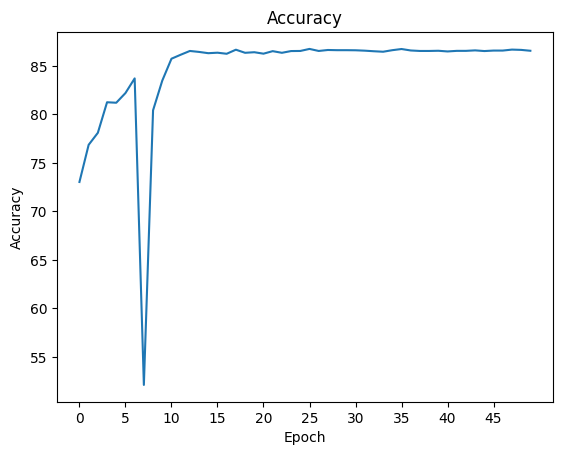

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

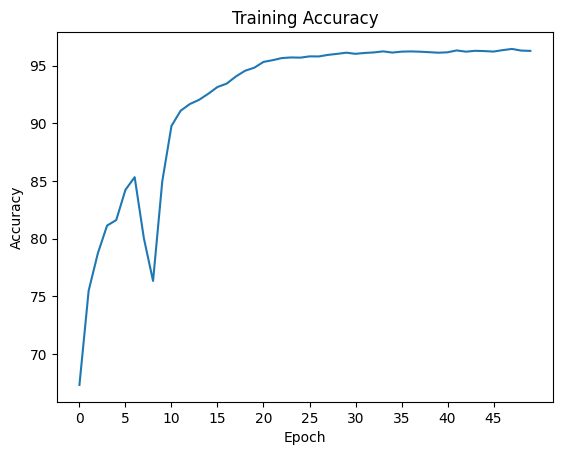

In [10]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

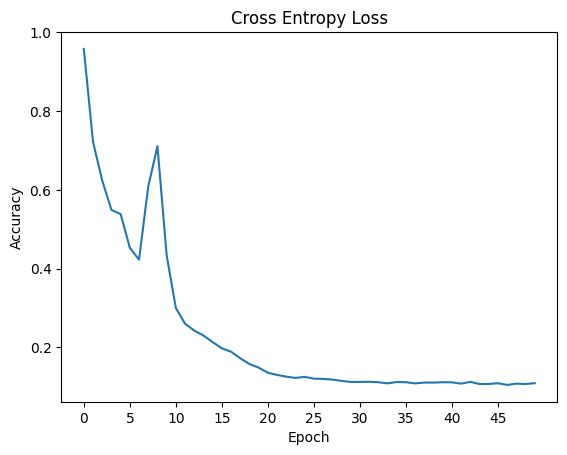

In [11]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()